In [132]:
import os
import json
import pickle
import random
import operator

import numpy as np
from tqdm import tqdm

from transformers import AutoModel, AutoTokenizer, AutoConfig

In [2]:
CORPUS = "CONLL2003_train"
EMBEDDING = "cl4l_bert-base-cased"
pretrained_model = "bert-base-cased"

with open("../../saved_embeddings/"+"_".join(CORPUS.split("_")[:-1])+"_"+EMBEDDING+".train", "rb") as outfile:
    embeddings = pickle.load(outfile)
with open("../../datasets/tokenized/"+CORPUS+".tags", "rb") as outfile:
    tags = json.load(outfile)
with open("../../datasets/tokenized/"+CORPUS+".tokenized", "rb") as outfile:
    tknzd_sent = json.load(outfile)

tokenizer_ = AutoTokenizer.from_pretrained(
        pretrained_model, do_basic_tokenize=False
    )
pretrained_tknzd = [
        tokenizer_(
            sent,
            return_tensors="pt",
            is_pretokenized=True,
            max_length=512,
            truncation=True,
        )
        for sent in tqdm(tknzd_sent)
    ]

100%|██████████| 14041/14041 [00:05<00:00, 2655.20it/s]


In [3]:
temp = []
for i in tqdm(range(len(pretrained_tknzd))):
    temp_sent = [embeddings[i][0]]
    # n = 1
    for j in range(1, len(embeddings[i])):
        if (
            tokenizer_.decode([pretrained_tknzd[i]["input_ids"][0][j + 1]])[0]
            == "#"
        ):
            temp_sent[-1] = temp_sent[-1] + embeddings[i][j]
            # n = n + 1
        else:
            temp_sent.append(embeddings[i][j])
    temp.append(temp_sent[:])

    # Truncation for tags and actual tokens, truncation can be done explicitly (rather than seperately)
    tknzd_sent[i] = tknzd_sent[i][: len(temp_sent)]
    tags[i] = tags[i][: len(temp_sent)]
   
embeddings = temp

100%|██████████| 14041/14041 [00:05<00:00, 2780.64it/s]


In [20]:
P = 2

embeddingsFlat = [np.array(word) for sent in embeddings for word in sent]
tagsFlat = [tag for sent in tags for tag in sent]

classes = list(set(tagsFlat))

tags_dict = {} 
for i in range(len(classes)):
    if classes[i] not in list(tags_dict.keys()):
        key = classes[i][P:]
        if key == '': key = 'O'
        tags_dict.update({key:i})
tags_dict = {list(tags_dict.keys())[i]: i for i in range(len(tags_dict.keys()))}
tags_dictInv = {v: k for k, v in tags_dict.items()}

tagsFlatKey = [tags_dict[t[P:]] if t[P:] != '' else tags_dict[t[:]] for t in tagsFlat]

In [21]:
NUM_TOKEN = len(tagsFlatKey)
maskedTags = np.array(tagsFlatKey.copy())
maskedTags[list(random.sample(range(NUM_TOKEN),(NUM_TOKEN*98)//100))]=-1

In [53]:
tags_dictActual = {"ORG":"Organization", "MISC":"Miscellaneous", "PER":"Person", "LOC":"Location", "O":"Other"}
print(tags_dict)
print(tags_dictInv)
print(set(tagsFlatKey))

{'O': 0, 'ORG': 1, 'MISC': 2, 'PER': 3, 'LOC': 4}
{0: 'O', 1: 'ORG', 2: 'MISC', 3: 'PER', 4: 'LOC'}
{0, 1, 2, 3, 4}


In [86]:
import umap
embedding = umap.UMAP(n_neighbors=40, min_dist=0.0).fit_transform(embeddingsFlat, y=maskedTags)

/cta/users/aosman/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [7]:
if P == 0:
    embNAME = "./embeddingP2-"+CORPUS+".npy"
elif P==2:
    embNAME = "./embeddingP2IO-"+CORPUS+".npy"
else:
    raise ValueError("wrong name format!")

In [8]:
embedding = np.load(embNAME)

In [84]:
tags_dropped = np.array([t for t in tagsFlatKey if t!=tags_dict['O']])
embedding_dropped = np.array([embedding[i] for i in range(len(embedding)) if tagsFlatKey[i]!=tags_dict['O']])

In [135]:
import matplotlib as mpl
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 20

mpl.rc("font", size=SMALL_SIZE)  # controls default text sizes
mpl.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
mpl.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
mpl.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
mpl.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
mpl.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
mpl.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

mpl.rcParams["axes.grid"] = False
mpl.rcParams["grid.alpha"] = 0.7
mpl.rcParams["grid.color"] = "#cccccc"
mpl.rcParams["grid.linestyle"] = "-"

mpl.rcParams["xtick.major.size"] = 3
mpl.rcParams["xtick.major.width"] = 1.4
mpl.rcParams["xtick.minor.size"] = 2
mpl.rcParams["xtick.minor.width"] = 1

mpl.rcParams["ytick.major.size"] = 3
mpl.rcParams["ytick.major.width"] = 1.5
mpl.rcParams["ytick.minor.size"] = 2
mpl.rcParams["ytick.minor.width"] = 1

if not os.path.exists("../../evaluations/embeddings_plot/"):
    os.mkdir("../../evaluations/embeddings_plot/")

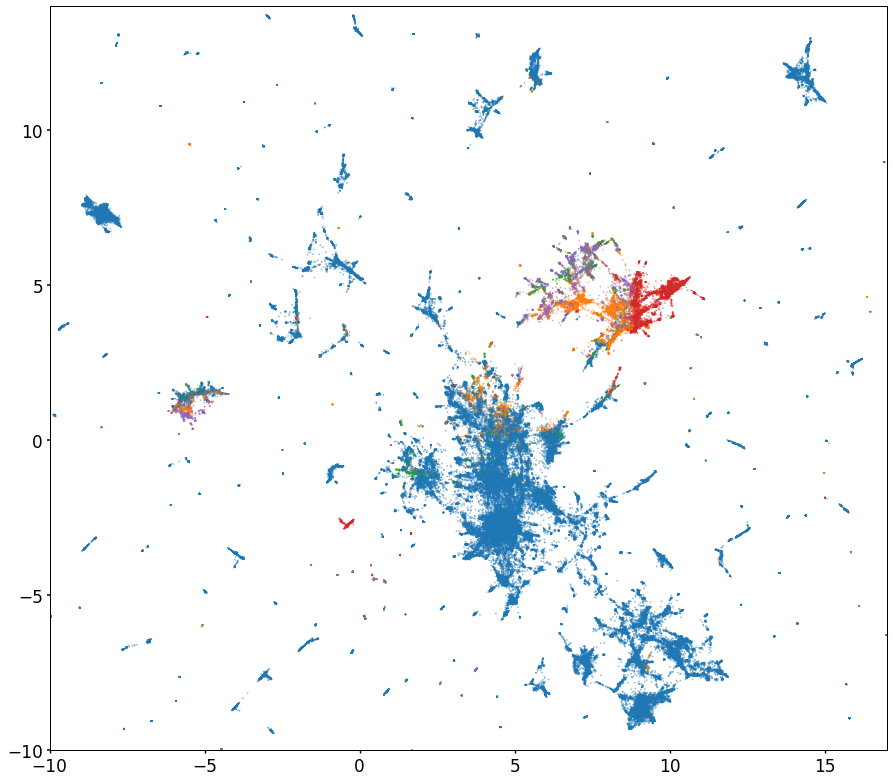

In [136]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns
sns.axes_style("ticks")

palette = np.array(sns.color_palette('tab10', len(classes)))
fig = plt.figure(figsize=(15,15))
ax = plt.subplot(aspect="equal")

sc = ax.scatter(
        (embedding[:,0]),
        (embedding[:, 1]),
        lw=0,
        s=3,
        c=(palette[tagsFlatKey]),
        alpha=0.5,
         rasterized=True
    )
"""
for c in range(0, len(classes)):
    x_ = np.mean(embedding[(np.array(tagsFlatKey) == c, 0)])
    y_ = np.mean(embedding[(np.array(tagsFlatKey) == c, 1)])
    ax.annotate(
        (str(c)),
        (x_, y_),
        horizontalalignment="center",
        verticalalignment="center",
        size=15,
        weight="bold",
    )
"""
"""
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.79, box.height * 0.79])
legend_TN = [
    patches.Patch(color=(palette[i]), label=tags_dictActual[tags_dictInv[i]]) for i in range(0, len(tags_dict))
]
l = ax.legend(
    loc="upper center",
    bbox_to_anchor=(1, .5),
    handles=legend_TN,
    borderaxespad=(-5),
)
l.set_title(title="Entity Class")
ax.add_artist(l)
"""
# ax.set_ylabel("UMAP-Y")
# ax.set_xlabel("UMAP-X")

ax.set_ylim(-10,14)
ax.set_xlim(-10,17)  
fig.savefig(
        "../../evaluations/embeddings_plot/embedding_"+CORPUS+".svg",
        bbox_inches="tight",
        pad_inches=0.1,
        dpi = 200,
    )

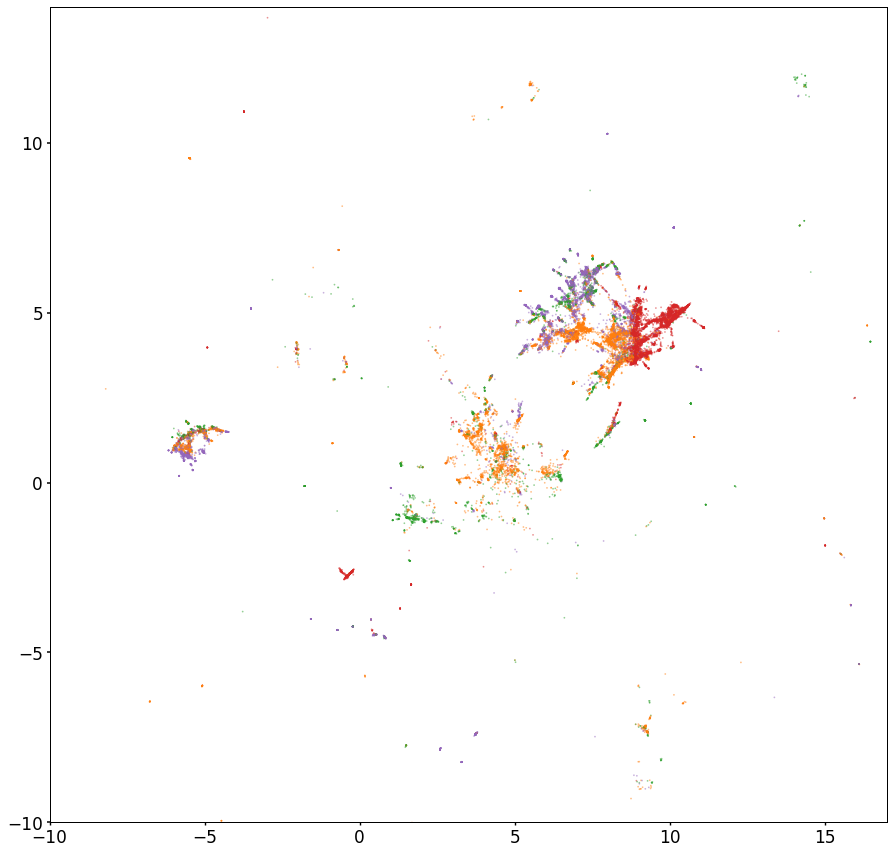

In [137]:
fig2 = plt.figure(figsize=(15,15))
ax2 = plt.subplot()
sc = ax2.scatter(
        (embedding_dropped[:,0]),
        (embedding_dropped[:, 1]),
        lw=0,
        s=3,
        c=(palette[tags_dropped]),
        alpha=0.5,
         rasterized=True
    )

# ax2.set_ylabel("UMAP-Y")
# ax2.set_xlabel("UMAP-X")

ax2.set_ylim(-10,14)
ax2.set_xlim(-10,17)  

fig2.savefig(
        "../../evaluations/embeddings_plot/embedding_"+CORPUS+"noOther.svg",
        bbox_inches="tight",
        pad_inches=0.1,
        dpi = 200,
    )

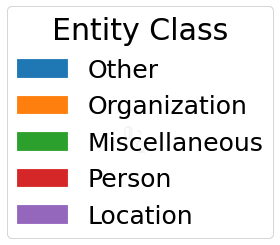

In [138]:
fig3 = plt.figure(figsize=(8,8))
ax3 = plt.subplot()
box = ax3.get_position()
ax3.set_position([box.x0, box.y0, box.width *0, box.height * 0])
legend_TN = [
    patches.Patch(color=(palette[i]), label=tags_dictActual[tags_dictInv[i]]) for i in range(0, len(tags_dict))
]
l = ax3.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 0.5),
    handles=legend_TN,
    borderaxespad=(-5),
    prop={'size': 25}
)
l.set_title(title="Entity Class", prop={'size':30})
ax3.add_artist(l)
fig3.savefig(
        "../../evaluations/embeddings_plot/legend_"+CORPUS+".svg",
        bbox_inches="tight",
        pad_inches=0.1,
        dpi = 200,
    )